# LSTM

## Requirements
- python 3.7
- keras
- tensorflow
- scikit-learn
- matplotlib
- seaborn
- pandas
- numpy
- wandb
- plaidMl (optional, only required when using AMD GPU) | [https://github.com/plaidml/plaidml](https://github.com/plaidml/plaidml)

## Variables

In [2]:
# -- IMPORTS --

# PlaidML Imports - disable if you make use of cudnn
amd = False

# -- DATA --

datasets = {
    0: ('data/sendlab/2019-ETI-EMON-V01-695FA5-1640EF.csv', '695FA5.hdf5'),
    1: ('data/sendlab/2019-ETI-EMON-V01-C602ED-1640EF.csv', 'C602ED.hdf5'),
    2: ('data/sendlab/2019-ETI-EMON-V01-C6007C-1640EF.csv', 'C6007C.hdf5')
}

# current_file determines which dataset will be used to train the model with.
current_file = datasets[2]

data_location = current_file[0]


# determines whether we apply data analysis to the dataset.
do_analysis = True

# -- MODEL BUILDING --

# no. hours to forecast
n_forecasts = 8

# determines how much data is used to forecast
n_input = n_forecasts * 3

# determines if the data will be scaled
use_scaled = False

# determines whether we're going to train or evaluate an existing model
training = False

# determines whether we're going to train a new model or continue training a existing model
resume_training = False

# sets filepath where model gets saved / loaded from if resume_training = True
model_location = current_file[1]


# -- HYPERPARAMETERS --

epochs = 10000

batch_size = 8

verbose = 1

learning_rate = 0.00001

# determines after how many epochs the model gets saved (aka after each n-th epoch)
n_checkpoint = 100

activation_function = 'relu'



# FORECASTING
# seaborn chart sizes
figure_width, figure_height = 14, 5

# how many hours into the past should be displayed in the chart?
history_length = 72

## Imports

In [3]:
import pandas as pd
import numpy as np
import datetime
import os

if amd:
    import plaidml.keras
    plaidml.keras.install_backend()
    os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
    os.environ['KMP_DUPLICATE_LIB_OK']='True'
#     os.environ['PLAIDML_USE_STRIPE']='1'
#     os.environ['PLAIDML_VERBOSE']='1'

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(figure_width, figure_height)})

import wandb
from wandb.keras import WandbCallback

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout, TimeDistributed, RepeatVector
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l1, l2

if training:
    wandb.init(project="smartgrid-lstm-open")

Using TensorFlow backend.
wandb: WARNING Keras version 2.3.1 is not fully supported. Required keras >= 2.4.0


## Methods

In [4]:
def to_supervised(train, n_input, n_output=8):
    X, y = list(),list()
    
    X_start = 0
    
    # iterate over train dataset
    for _ in range(len(train)):
        
        # set the ranges for input + output
        X_end = X_start + n_input
        y_end = X_end + n_output
        
        # check if data contains enough samples for sequence
        if y_end <= len(train):
            X.append(train[X_start:X_end, :])
            y.append(train[X_end:y_end, 0])
            
        X_start += 1
    assert len(X) > 0, "Unable to transform given data into a supervised format. \n train size: ({}), n_input+n_output: ({})".format(len(train), n_input+n_output)
    return np.array(X), np.array(y)

def build_model(data, n_input, params):
    
    # data preperation
    train, val = data
    X_train, y_train = to_supervised(train, n_input)
    X_val, y_val = to_supervised(val, n_input)
    
    # meta / parameters
    epochs, batch_size, verbose, learning_rate, n_checkpoint, model_location, resume_training, activation_function = params
    n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

    # reshape output
    y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
    y_val = y_val.reshape((y_val.shape[0], y_val.shape[1], 1))
    
    
    if resume_training:
        model = load_model(model_location)
    else:   
        model = Sequential()
        model.add(LSTM(256, activation=activation_function, input_shape=(n_timesteps, n_features)))
        model.add(Dropout(.4))
        model.add(RepeatVector(n_outputs))
        model.add(LSTM(256, activation=activation_function, return_sequences=True))
        model.add(Dropout(.2))
        model.add(LSTM(256, activation=activation_function, return_sequences=True))
        model.add(Dropout(.2))
        model.add(TimeDistributed(Dense(64, activation=activation_function)))
        model.add(TimeDistributed(Dense(64, activation=activation_function)))
        model.add(TimeDistributed(Dense(1, activation=activation_function)))
        opt = Adam(lr=learning_rate)
        model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])
        
    checkpoint = ModelCheckpoint(model_location, monitor='loss', verbose=1, save_best_only=True, mode='auto', period=n_checkpoint)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_data=(X_val, y_val), callbacks=[WandbCallback(),checkpoint], shuffle=False)
    
#     model.save(os.path.join(wandb.run.dir, "model.h5"))
    
    # plot the model
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['accuracy'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    
    return model

def forecast(model, history, n_input):
    data = np.array(history)
    X = data[-n_input:, :]
    X = X.reshape((1, X.shape[0], X.shape[1]))
    yhat = model.predict(X, verbose=0)
    yhat = yhat[0]
    return yhat

def visualize_forecast(history, validation, future, pred, future_pred, n_input, n_forecasts, history_length=48):
    if n_input > history_length:
        past = history[-history_length:-n_forecasts+1]
    else:   
        past = history[-n_input:-n_forecasts+1]
    
    future = future[-n_forecasts:]
    validation = validation[-n_forecasts:]

    validation.index = validation.index + pd.Timedelta(n_forecasts, unit='h')
    future.index = future.index + pd.Timedelta(n_forecasts, unit='h')

    future['Prediction'] = future_pred
    validation['Prediction'] = pred
    validation['Actual'] = history[-8:]['Actueel verbruik']
    
    sns.lineplot(data=past, x=past.index, y="Actueel verbruik")
    sns.lineplot(data=validation, x=validation.index, y="Actual", color="lime")
    sns.lineplot(data=validation, x=validation.index, y="Prediction", color="red")
    sns.lineplot(data=future, x=future.index, y="Prediction", color="darkred")
    plt.legend(['Actueel verbruik (Past)','Actueel verbruik (Actual)','Actueel verbruik (Prediction)', 'Actueel verbruik (Future Prediction)'])

    plt.title('Predictions of Actueel verbruik')
    plt.xlabel('Timeline')
    plt.ylabel('Actueel verbruik')
    plt.grid(which='major', color="#ffffff", alpha=.5)
    plt.axvline(x=past.index[-1], color="green", linestyle="--")
    plt.axvline(x=validation.index[-1], color="green", linestyle="--")
    plt.show()
    
    print(future)
def to_datetime(timestamp):    
    return np.datetime64(timestamp)
def output_data(data, predictions, n_forecasts):
    data = data[-n_forecasts:]
    data['Prediction'] = predictions
    data = data['Prediction']
    return data

## Data Analysis

In [5]:
data = pd.read_csv(data_location, index_col='Timestamp')
data.index = data.index.map(to_datetime)
data['Totaal vermogen ontvangen'] = data['Totaal vermogen ontvangen in tariff 1 in KWH'] + data['Totaal vermogen ontvangen in tariff 2 in KWH']

C:\Users\moham\anaconda3\envs\ztdl-updated\lib\site-packages\ipykernel_launcher.py:112: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


Number of rows: 285 

Number of rows (NaN excluded): 285 


Days in dataset (after setting index):
   2020-12-10 00:00:00
   2020-12-11 00:00:00
   2020-12-12 00:00:00
   2020-12-13 00:00:00
   2020-12-14 00:00:00
   2020-12-15 00:00:00
   2020-12-16 00:00:00
   2020-12-17 00:00:00
   2020-12-18 00:00:00
   2020-12-19 00:00:00
   2020-12-20 00:00:00
   2020-12-21 00:00:00
   2020-12-22 00:00:00

Days with NaN's:




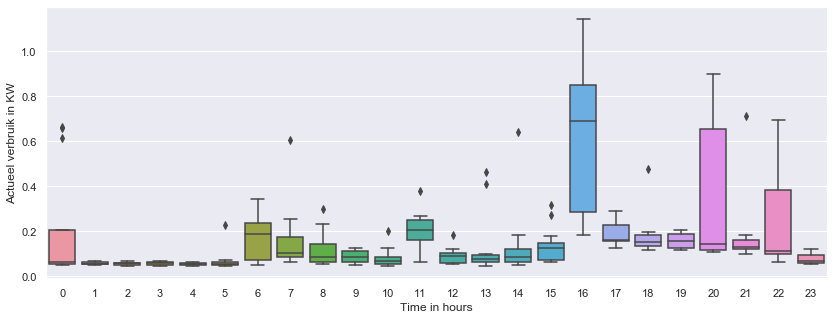

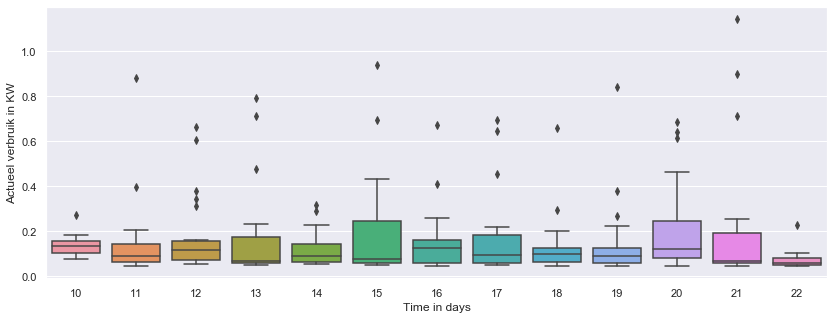

In [6]:
if do_analysis:
    columns = [x for x in data.columns if x in ['Actueel verbruik in KW', 'Totaal vermogen ontvangen in tariff 1 in KWH', 'Totaal vermogen ontvangen in tariff 2 in KWH', 'Totaal vermogen ontvangen']]
    data_resample = pd.DataFrame(columns=columns)
    data_resample['Actueel verbruik in KW'] = data['Actueel verbruik in KW'].resample('h').mean()
    data_resample['Totaal vermogen ontvangen in tariff 1 in KWH'] = data['Totaal vermogen ontvangen in tariff 1 in KWH'].resample('h').max()
    data_resample['Totaal vermogen ontvangen in tariff 2 in KWH'] = data['Totaal vermogen ontvangen in tariff 2 in KWH'].resample('h').max()
    data_resample['Totaal vermogen ontvangen'] = data['Totaal vermogen ontvangen'].resample('h').max()

    print("Number of rows: {} \n".format(len(data_resample)))
    print("Number of rows (NaN excluded): {} \n".format(len(data_resample[~np.isnan(data_resample['Totaal vermogen ontvangen'])])))
    print("")
    print("Days in dataset (after setting index):")
    for x in data_resample.resample('d').mean().index:
        print("  ", x)
    print("\nDays with NaN's:")
    for x in data_resample[np.isnan(data_resample['Totaal vermogen ontvangen'])].resample('d').mean().index:
        print("  ", x)
    print("\n")
    sns.boxplot(x=data_resample.index.hour, y=data_resample['Actueel verbruik in KW'])
    plt.xlabel('Time in hours')
    plt.show()
    sns.boxplot(x=data_resample.index.day, y=data_resample['Actueel verbruik in KW'])
    plt.xlabel('Time in days')
    plt.show()

## Data Preperation

In [7]:
df = pd.DataFrame()
# set to mean to get kw/h, sum for kw.
df['Actueel verbruik'] = data['Actueel verbruik in KW'].resample('h').mean()

# remove NaN's from dataset
df = df[~np.isnan(df['Actueel verbruik'])]

# add time-related information to dataset
df['Month'] = df.index.month
df['Week'] = df.index.week
df['Day'] = df.index.day
df['Hour'] = df.index.hour
# df['Totaal vermogen ontvangen'] = data['Totaal vermogen ontvangen'].resample('h').max()

df.head()

,Actueel verbruik,Month,Week,Day,Hour
Timestamp,,,,,
2020-12-10 12:00:00,0.120000,12,50,10,12
2020-12-10 13:00:00,0.073391,12,50,10,13
2020-12-10 14:00:00,0.113103,12,50,10,14
2020-12-10 15:00:00,0.098613,12,50,10,15
2020-12-10 16:00:00,0.270517,12,50,10,16


In [8]:
# Fill NaN's with column's mean value
for j in range(0,len(df.columns)):        
        df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())

## Model building

In [9]:
df_future = df[-n_input:]
df_pred = df[-(n_input+n_forecasts):-n_forecasts]
df_resample = df[:-n_forecasts*2]

if use_scaled:
    scaler = MinMaxScaler()
    df_pred_scaled = scaler.fit_transform(df_pred)
    df_future_scaled = scaler.fit_transform(df_future)
    train, val = train_test_split(scaler.fit_transform(df_resample), test_size=.4, shuffle=False, stratify=None)
else:
    train, val = train_test_split(df_resample.values, test_size=.4, shuffle=False, stratify=None)

In [10]:
df_resample

,Actueel verbruik,Month,Week,Day,Hour
Timestamp,,,,,
2020-12-10 12:00:00,0.120000,12,50,10,12
2020-12-10 13:00:00,0.073391,12,50,10,13
2020-12-10 14:00:00,0.113103,12,50,10,14
2020-12-10 15:00:00,0.098613,12,50,10,15
2020-12-10 16:00:00,0.270517,12,50,10,16
2020-12-10 17:00:00,0.160636,12,50,10,17
2020-12-10 18:00:00,0.149023,12,50,10,18
2020-12-10 19:00:00,0.179655,12,50,10,19
2020-12-10 20:00:00,0.141676,12,50,10,20


In [11]:
if training:
    # throw error if n_input is too big
    assert n_input+n_forecasts < len(val), "n_input + n_forecasts ({}) is larger than the amount of validation samples ({}) ".format(n_input+n_forecasts, len(val))
    
    
    data = [train, val]
    params = [epochs, batch_size, verbose, learning_rate, n_checkpoint, model_location, resume_training, activation_function]
    model = build_model(data, n_input, params)
else:
    model = load_model(model_location)

## Forecasting & Visualizing

In [ ]:
if use_scaled:
    pred = forecast(model, df_pred_scaled, n_input)
    future = forecast(model, df_future_scaled, n_input)
    
    _ = np.zeros([len(pred), len(df_pred.columns)])
    
    _[:,0] = np.squeeze(pred)
    pred = scaler.inverse_transform(_)
    
    _[:,0] = np.squeeze(future)
    future_pred = scaler.inverse_transform(_)

    visualize_forecast(df, df_pred, df_future, pred[:,0], future_pred[:,0], n_input, n_forecasts, history_length)
else:
    pred = forecast(model, df_pred, n_input)
    future_pred = forecast(model, df_future, n_input)
    
    # Prepare dataframes for plotting
    visualize_forecast(df, df_pred, df_future, pred, future_pred, n_input, n_forecasts, history_length)


In [ ]:
print(output_data())